# Predict Service Utilization
Use Random Forests and Gradient Boosted Forests (XGBoost) to predict targets which we believe IC Laws may influence, and evaluate the influence of IC Laws on the rate of relapse.  Evaluate models with and without state included as a predictor

### Import and prepare data

In [2]:
## Load modules
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier as GBClass
from sklearn.ensemble import GradientBoostingClassifier as GBRreg

## Specify WD
#wd = "/home/abf/BINF667013_Final_Project/"
wd = (
    "/Users/adam/Documents/BINF667013_BigDataAnalyticsHealthcare/" +
    "Final_Project/TEDS_Study"
)
os.chdir(wd)

## Load data
# teds_laws = pd.read_csv("analysis_objects/teds_laws.csv")
teds_imp_laws = pd.read_csv(
    "analysis_objects/teds_imp_laws.csv"
)

### Define A function to flag relapses
def relapse(x, **kwargs):
    if  (
            x['SUB1'] == kwargs['drug'] and (
            x['SUB1_D'] == kwargs['drug'] or\
            x['SUB2_D'] == kwargs['drug'] or\
            x['SUB3_D'] == kwargs['drug']
        )
    ):
        return 1
    else:
        return 0


## Add Relapse Columns
teds_imp_laws = teds_imp_laws.assign(
    alc_cases = lambda x: x.loc[:,['SUB1']].apply(lambda x: x['SUB1'] == 2, axis=1),
    hrn_cases = lambda x: x.loc[:,['SUB1']].apply(lambda x: x['SUB1'] == 5, axis=1),
    met_cases = lambda x: x.loc[:,['SUB1']].apply(lambda x: x['SUB1'] == 10, axis=1),
    alc_relapse = lambda x: x.loc[:,['SUB1', 'SUB1_D', 'SUB2_D', 'SUB3_D']].apply(relapse, axis=1, drug=2),
    hrn_relapse = lambda x: x.loc[:,['SUB1', 'SUB1_D', 'SUB2_D', 'SUB3_D']].apply(relapse, axis=1, drug=5),
    met_relapse = lambda x: x.loc[:,['SUB1', 'SUB1_D', 'SUB2_D', 'SUB3_D']].apply(relapse, axis=1, drug=10)
)




### Predict Relapse by Primary Substance, with IC Laws

/Users/adam/opt/anaconda3/envs/binf667013_final_project/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/adam/opt/anaconda3/envs/binf667013_final_project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


              precision    recall  f1-score   support

         1.0      1.000     1.000     1.000        24
         2.0      1.000     1.000     1.000       461
         3.0      1.000     1.000     1.000         4
         4.0      1.000     1.000     1.000       274
         5.0      1.000     1.000     1.000       141
         6.0      1.000     1.000     1.000       315
         7.0      1.000     1.000     1.000       917
         8.0      1.000     1.000     1.000        32

    accuracy                          1.000      2168
   macro avg      1.000     1.000     1.000      2168
weighted avg      1.000     1.000     1.000      2168

              precision    recall  f1-score   support

         1.0      1.000     0.800     0.889        10
         2.0      0.995     0.975     0.985       197
         3.0      0.000     0.000     0.000         2
         4.0      0.966     0.975     0.970       118
         5.0      0.952     0.984     0.968        61
         6.0      0.971 

<AxesSubplot:xlabel='Feature', ylabel='Importance'>

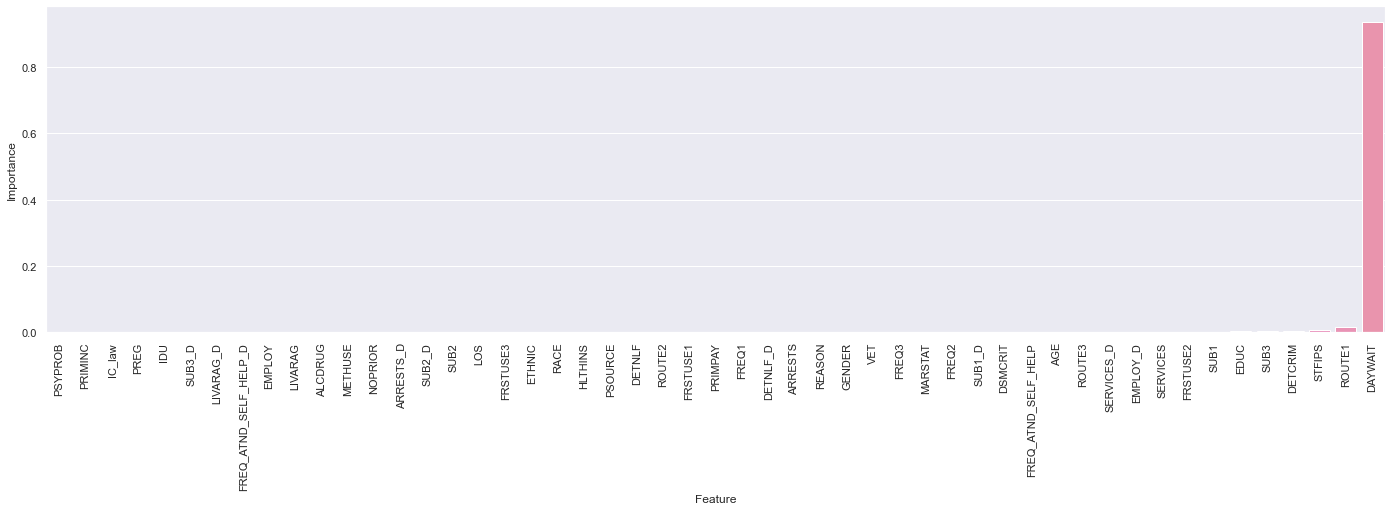

In [5]:
## Drop extraneous features
keep = ["IC_law", "alc_cases"]
drop = teds_imp_laws.iloc[:,76:].columns.difference(keep).append(pd.Index([
    'ALCFLG', 'COKEFLG', 'MARFLG', 'HERFLG','Jurisdiction',
    'METHFLG', 'OPSYNFLG', 'PCPFLG', 'FREQ1_D','FREQ2_D','FREQ3_D','HALLFLG',
    'MTHAMFLG', 'AMPHFLG','STIMFLG','BENZFLG', 'TRNQFLG','BARBFLG',
    'SEDHPFLG','INHFLG', 'OTCFLG', 'STATE','OTHERFLG','CBSA2010', 
    'REGION', 'DIVISION'
]))
data=teds_imp_laws.drop(columns=drop)


## Divide data into training and validation sets, stratified by alcohol relapse
from sklearn.model_selection import train_test_split as split
alc_train, alc_test = split(
    data[data.alc_cases == 1], 
    train_size=0.7,
    stratify=data[data.alc_cases == 1].SERVICES
)

### Fit a Gradient Boosted Model to alcohol relapses. 
clf=GridSearchCV(
    GBClass(loss='deviance'),
    param_grid={
        "learning_rate":[0.00001, 0.0001, 0.001, 0.01, 0.1],
        "n_estimators":[50, 100, 250, 500],
        "subsample":[0.8, 1]
    },
    n_jobs = -1,
    scoring="balanced_accuracy", cv=5
)

model=clf.fit(
    X=alc_train.drop(columns=['SERVICES']),
    y=alc_train['SERVICES']
)


print("Predictions on the Training Data")
train_pred=model.predict(alc_train.drop(columns=['SERVICES']))
print(
    confusion_matrix(alc_train['SERVICES'], train_pred)
)
print(classification_report(
    alc_train['SERVICES'], train_pred, zero_division=1,
    digits=3)
)

print("Predictions on the Testing Data")
test_pred=model.predict(alc_test.drop(columns=['SERVICES']))
print(
    confusion_matrix(alc_test['SERVICES'], ttest_pred)
)
print(classification_report(
    alc_test['SERVICES'], test_pred, zero_division=1,
    digits=3)
)


## Extract and print parameters for best model
best = model.best_estimator_
print(best)

## Extract Importance and Rank Features
imp = best.feature_importances_
imp={i:imp[i] for i in range(0, len(imp))}
z=alc_train.columns.to_list()

sorted_imp = sorted(imp.items(), key=lambda kv: kv[1])
sorted_imp
importance = pd.DataFrame({
    "Feature": [z[i] for i in [i[0] for i in sorted_imp]],
    "Importance": [i[1] for i in sorted_imp]
})

#print(importance)
sns.set(rc = {'figure.figsize':(24,6)})
plt.xticks(rotation=90)
sns.barplot(x='Feature', y='Importance', data=importance)

              precision    recall  f1-score   support

         1.0      1.000     1.000     1.000        29
         2.0      1.000     1.000     1.000       452
         3.0      1.000     1.000     1.000         6
         4.0      1.000     1.000     1.000       220
         5.0      1.000     1.000     1.000       173
         6.0      1.000     1.000     1.000       252
         7.0      1.000     1.000     1.000       678
         8.0      1.000     1.000     1.000        16

    accuracy                          1.000      1826
   macro avg      1.000     1.000     1.000      1826
weighted avg      1.000     1.000     1.000      1826

              precision    recall  f1-score   support

         1.0      1.000     1.000     1.000        12
         2.0      0.985     0.995     0.990       194
         3.0      1.000     1.000     1.000         2
         4.0      0.989     0.968     0.979        95
         5.0      0.986     0.959     0.973        74
         6.0      0.991 

<AxesSubplot:xlabel='Feature', ylabel='Importance'>

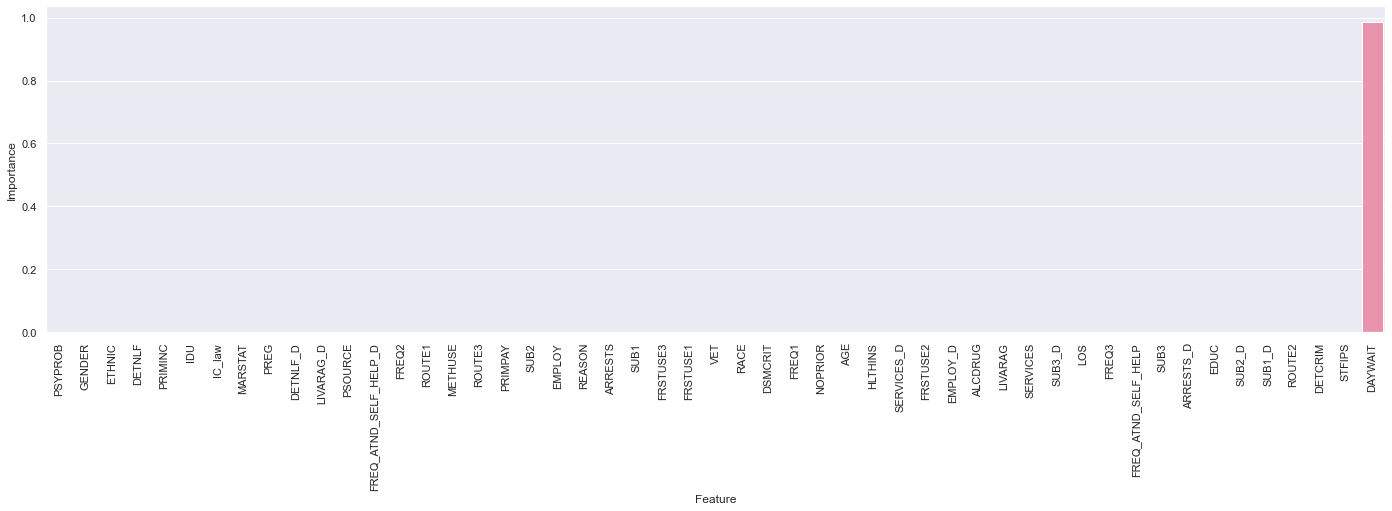

In [7]:
## Drop extraneous features
keep = ["IC_law", "hrn_cases"]
drop = teds_imp_laws.iloc[:,76:].columns.difference(keep).append(pd.Index([
    'ALCFLG', 'COKEFLG', 'MARFLG', 'HERFLG','Jurisdiction',
    'METHFLG', 'OPSYNFLG', 'PCPFLG', 'FREQ1_D','FREQ2_D','FREQ3_D','HALLFLG',
    'MTHAMFLG', 'AMPHFLG','STIMFLG','BENZFLG', 'TRNQFLG','BARBFLG',
    'SEDHPFLG','INHFLG', 'OTCFLG', 'STATE','OTHERFLG','CBSA2010', 
    'REGION', 'DIVISION'
]))
data=teds_imp_laws.drop(columns=drop)


## Divide data into training and validation sets, stratified by alcohol relapse
from sklearn.model_selection import train_test_split as split
hrn_train, hrn_test = split(
    data[data.hrn_cases == 1], 
    train_size=0.7,
    stratify=data[data.hrn_cases == 1].SERVICES
)

### Fit a Gradient Boosted Model to alcohol relapses. 
clf=GridSearchCV(
    GBClass(loss='deviance'),
    param_grid={
        "learning_rate":[0.00001, 0.0001, 0.001, 0.01, 0.1],
        "n_estimators":[50, 100, 250, 500],
        "subsample":[0.8, 1]
    },
    n_jobs = -1,
    scoring="balanced_accuracy", cv=5
)

model=clf.fit(
    X=hrn_train.drop(columns=['SERVICES']),
    y=hrn_train['SERVICES']
)


print("Predictions on the Training Data")
train_pred=model.predict(hrn_train.drop(columns=['SERVICES']))
print(
    confusion_matrix(hrn_train['SERVICES'], train_pred)
)
print(classification_report(
    hrn_train['SERVICES'], train_pred, zero_division=1,
    digits=3)
)

print("Predictions on the Testing Data")
test_pred=model.predict(hrn_test.drop(columns=['SERVICES']))
print(
    confusion_matrix(hrn_test['SERVICES'], test_pred)
)
print(classification_report(
    hrn_test['SERVICES'], test_pred, zero_division=1,
    digits=3)
)

## Extract and print parameters for best model
best = model.best_estimator_
print(best)

## Extract Importance and Rank Features
imp = best.feature_importances_
imp={i:imp[i] for i in range(0, len(imp))}
z=hrn_train.columns.to_list()

sorted_imp = sorted(imp.items(), key=lambda kv: kv[1])
sorted_imp
importance = pd.DataFrame({
    "Feature": [z[i] for i in [i[0] for i in sorted_imp]],
    "Importance": [i[1] for i in sorted_imp]
})

#print(importance)
sns.set(rc = {'figure.figsize':(24,6)})
plt.xticks(rotation=90)
sns.barplot(x='Feature', y='Importance', data=importance)

In [ ]:
## Drop extraneous features
keep = ["IC_law", "met_cases"]
drop = teds_imp_laws.iloc[:,76:].columns.difference(keep).append(pd.Index([
    'ALCFLG', 'COKEFLG', 'MARFLG', 'HERFLG','Jurisdiction',
    'METHFLG', 'OPSYNFLG', 'PCPFLG', 'FREQ1_D','FREQ2_D','FREQ3_D','HALLFLG',
    'MTHAMFLG', 'AMPHFLG','STIMFLG','BENZFLG', 'TRNQFLG','BARBFLG',
    'SEDHPFLG','INHFLG', 'OTCFLG', 'STATE','OTHERFLG','CBSA2010', 
    'REGION', 'DIVISION'
]))
data=teds_imp_laws.drop(columns=drop)


## Divide data into training and validation sets, stratified by alcohol relapse
from sklearn.model_selection import train_test_split as split
met_train, met_test = split(
    data[data.met_cases == 1], 
    train_size=0.7,
    stratify=data[data.met_cases == 1].SERVICES
)

### Fit a Gradient Boosted Model to alcohol relapses. 
clf=GridSearchCV(
    GBClass(loss='deviance'),
    param_grid={
        "learning_rate":[0.00001, 0.0001, 0.001, 0.01, 0.1],
        "n_estimators":[50, 100, 250, 500],
        "subsample":[0.8, 1]
    },
    n_jobs = -1,
    scoring="balanced_accuracy", cv=5
)

model=clf.fit(
    X=met_train.drop(columns=['SERVICES']),
    y=met_train['SERVICES']
)

print("Predictions on the Training Data")
train_pred=model.predict(met_train.drop(columns=['SERVICES']))
print(
    confusion_matrix(met_train['SERVICES'], train_pred)
)
print(classification_report(
    met_train['SERVICES'], train_pred, zero_division=1,
    digits=3)
)

print("Predictions on the Testing Data")
test_pred=model.predict(met_test.drop(columns=['SERVICES']))
print(
    confusion_matrix(met_test['SERVICES'], test_pred)
)
print(classification_report(
    met_test['SERVICES'], test_pred, zero_division=1,
    digits=3)
)


## Extract and print parameters for best model
best = model.best_estimator_
print(best)

## Extract Importance and Rank Features
imp = best.feature_importances_
imp={i:imp[i] for i in range(0, len(imp))}
z=met_train.columns.to_list()

sorted_imp = sorted(imp.items(), key=lambda kv: kv[1])
sorted_imp
importance = pd.DataFrame({
    "Feature": [z[i] for i in [i[0] for i in sorted_imp]],
    "Importance": [i[1] for i in sorted_imp]
})

#print(importance)
sns.set(rc = {'figure.figsize':(24,6)})
plt.xticks(rotation=90)
sns.barplot(x='Feature', y='Importance', data=importance)

In [ ]:
## Drop extraneous features
keep = ["hrn_cases", "hrn_relapse"]
drop = teds_imp_laws.iloc[:,76:].columns.difference(keep).append(pd.Index([
    'ALCFLG', 'COKEFLG', 'MARFLG', 'HERFLG', 'SUB1_D','Jurisdiction',
    'SUB2_D', 'SUB3_D','METHFLG', 'OPSYNFLG', 'PCPFLG', 'FREQ1_D',
    'FREQ2_D','FREQ3_D','HALLFLG', 'MTHAMFLG', 'AMPHFLG','STIMFLG', 
    'BENZFLG', 'TRNQFLG','BARBFLG', 'SEDHPFLG','INHFLG', 'OTCFLG',
    'STATE','OTHERFLG','CBSA2010', 'REGION', 'DIVISION','STFIPS'
]))
data=teds_imp_laws.drop(columns=drop)


## Divide data into training and validation sets, stratified by alcohol relapse
from sklearn.model_selection import train_test_split as split
hrn_train, hrn_test = split(
    data[data.hrn_cases == 1], 
    train_size=0.7,
    stratify=data[data.hrn_cases == 1].hrn_relapse
)

### Fit a Gradient Boosted Model to alcohol relapses. 
clf=GridSearchCV(
    GBClass(loss='deviance'),
    param_grid={
        "learning_rate":[0.00001, 0.0001, 0.001, 0.01, 0.1],
        "n_estimators":[50, 100, 250, 500],
        "subsample":[0.8, 1]
    },
    scoring="balanced_accuracy", cv=5
)

model=clf.fit(
    X=hrn_train.drop(columns=['hrn_relapse']),
    y=hrn_train['hrn_relapse']
)



train_pred=model.predict(hrn_train.drop(columns=['hrn_relapse']))
print(classification_report(
    hrn_train['hrn_relapse'], train_pred, zero_division=1,
    digits=3)
)

test_pred=model.predict(hrn_test.drop(columns=['hrn_relapse']))
print(classification_report(
    hrn_test['hrn_relapse'], test_pred, zero_division=1,
    digits=3)
)

## Extract and print parameters for best model
best = model.best_estimator_
print(best)

## Extract Importance and Rank Features
imp = best.feature_importances_
imp={i:imp[i] for i in range(0, len(imp))}
z=hrn_train.columns.to_list()

sorted_imp = sorted(imp.items(), key=lambda kv: kv[1])
sorted_imp
importance = pd.DataFrame({
    "Feature": [z[i] for i in [i[0] for i in sorted_imp]],
    "Importance": [i[1] for i in sorted_imp]
})

#print(importance)
sns.set(rc = {'figure.figsize':(24,6)})
plt.xticks(rotation=90)
sns.barplot(x='Feature', y='Importance', data=importance)

In [ ]:
## Drop extraneous features
keep = ["met_cases","met_relapse"]
drop = teds_imp_laws.iloc[:,76:].columns.difference(keep).append(pd.Index([
    'ALCFLG', 'COKEFLG', 'MARFLG', 'HERFLG', 'SUB1_D','Jurisdiction',
    'SUB2_D', 'SUB3_D','METHFLG', 'OPSYNFLG', 'PCPFLG', 'FREQ1_D',
    'FREQ2_D','FREQ3_D','HALLFLG', 'MTHAMFLG', 'AMPHFLG','STIMFLG', 
    'BENZFLG', 'TRNQFLG','BARBFLG', 'SEDHPFLG','INHFLG', 'OTCFLG',
    'STATE','OTHERFLG','CBSA2010', 'REGION', 'DIVISION','STFIPS'
]))
data=teds_imp_laws.drop(columns=drop)


## Divide data into training and validation sets, stratified by alcohol relapse
from sklearn.model_selection import train_test_split as split
met_train, met_test = split(
    data[data.met_cases == 1], 
    train_size=0.7,
    stratify=data[data.met_cases == 1].met_relapse
)

### Fit a Gradient Boosted Model to alcohol relapses. 
clf=GridSearchCV(
    GBClass(loss='deviance'),
    param_grid={
        "learning_rate":[0.00001, 0.0001, 0.001, 0.01, 0.1],
        "n_estimators":[50, 100, 250, 500],
        "subsample":[0.8, 1]
    },
    scoring="balanced_accuracy", cv=5
)

model=clf.fit(
    X=met_train.drop(columns=['met_relapse']),
    y=met_train['met_relapse']
)



train_pred=model.predict(met_train.drop(columns=['met_relapse']))
print(classification_report(
    met_train['met_relapse'], train_pred, zero_division=1,
    digits=3)
)

test_pred=model.predict(met_test.drop(columns=['met_relapse']))
print(classification_report(
    met_test['met_relapse'], test_pred, zero_division=1,
    digits=3)
)

## Extract and print parameters for best model
best = model.best_estimator_
print(best)

## Extract Importance and Rank Features
imp = best.feature_importances_
imp={i:imp[i] for i in range(0, len(imp))}
z=met_train.columns.to_list()

sorted_imp = sorted(imp.items(), key=lambda kv: kv[1])
sorted_imp
importance = pd.DataFrame({
    "Feature": [z[i] for i in [i[0] for i in sorted_imp]],
    "Importance": [i[1] for i in sorted_imp]
})

#print(importance)
sns.set(rc = {'figure.figsize':(24,6)})
plt.xticks(rotation=90)
sns.barplot(x='Feature', y='Importance', data=importance)